In [34]:
import os, getpass
from dotenv import load_dotenv, find_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


load_dotenv(find_dotenv())
os.environ["LANGCHAIN_PROJECT"] = "ex_module-1"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
model = ChatGoogleGenerativeAI(model="gemini-1.5-pro",temperature=0)

# Introduction to LangGraph - Module 1 exercises

## General Goals:
Make a simple agent that can retrieve weather information, and make a rundown of the latest news. The agent must be able to decide when to use the given tools

### 1.- Make a function that retrieves weather information from a weather API.

Hint: I used [Openweather](https://openweathermap.org/api), but use whichever you want! 


In [21]:
import requests
from typing import Dict
from datetime import datetime

def get_weather(city: str) -> Dict:
    """
    Retrieve current weather information for a given city.
    
    Args:
        city (str): Name of the city
        
    Returns:
        Dict: Weather information including temperature, conditions, and humidity
        
    Raises:
        Exception: If API request fails or city not found
    """
    # API configuration
    API_KEY = os.getenv("OPENWEATHER_API_KEY")  # Replace with your OpenWeatherMap API key
    BASE_URL = "http://api.openweathermap.org/data/2.5/weather"
    
    try:
        ### Convert city to lat and lon with geocoding API
        rs = requests.get(f"http://api.openweathermap.org/geo/1.0/direct?q={city}&limit=1&appid={API_KEY}").json()
        lat = rs[0]["lat"]
        lon = rs[0]["lon"]
        ### Get weather information
        # Build request parameters
        params = {
            'lat': lat,
            'lon': lon,
            'appid': API_KEY,
            'units': 'metric'  # Use Celsius for temperature
        }
        
        # Make API request
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()  # Raise exception for bad status codes
        
        # Parse response
        data = response.json()
        
        # Extract and format relevant weather information
        weather_info = {
            'temperature': round(data['main']['temp'], 1),
            'description': data['weather'][0]['description'],
            'humidity': data['main']['humidity'],
            'wind_speed': data['wind']['speed'],
            'last_updated': datetime.fromtimestamp(data['dt']).strftime('%Y-%m-%d %H:%M:%S')
        }
        
        return weather_info
    
    except requests.exceptions.HTTPError as e:
        if response.status_code == 404:
            raise Exception(f"City '{city}' not found")
        else:
            raise Exception(f"API request failed: {str(e)}")
    except Exception as e:
        raise Exception(f"Error getting weather data: {str(e)}")

In [23]:
get_weather("Garbayuela")

{'temperature': 12.8,
 'description': 'clear sky',
 'humidity': 42,
 'wind_speed': 5.36,
 'last_updated': '2025-02-03 13:41:26'}

### 2.- Make a function that retrieves the latest news about a given city.

Hint: I used [Tavily](https://tavily.com/) but, again, choose as you wish.

In [41]:
def get_news(city: str) -> Dict:
    '''
    Tool to get the latest news about a given city.
    
    Args:
        city (str): Name of the city
        
    Returns:
        Dict: Latest news about the city
    '''
    search = TavilySearchResults(max_results=4)
    return search.invoke(f"News of today about the city of {city}")

In [27]:
get_news("Garbayuela")

[{'url': 'https://turismolasiberia.juntaex.es/en/garbayuela',
  'content': 'We also find in Garbayuela a bronze sculpture of recent creation, which represents a woman with a child in her arms. Made by the award-winning creator of'},
 {'url': 'https://play.google.com/store/apps/details?id=es.bandomovil.garbayuela.informa&hl=en_US',
  'content': 'This tool will allow you to be immediately informed of the news, developments and events that occur in your city, regardless of where you are.'},
 {'url': 'https://properties.lefigaro.com/announces/luxury-real+estate-extremadura-spain/?ville=garbayuela',
  'content': 'Discover Real Estate listings of Luxury Properties for Sale in Garbayuela and Find the one of your Dreams! The most beautiful Holiday Properties for Sale in'},
 {'url': 'https://www.companyspace.com/property-statistics/new-premises-development/spain/warehouses/garbayuela',
  'content': 'On this property statistics page, you can see the development of the number of new available com

### 3.- Setup the LLM with the tools. Include a system message to the LLM to use the tools as necessary and to set the proper behavior.

In [42]:
model = ChatGoogleGenerativeAI(model="gemini-1.5-pro",temperature=0)
tools = [get_weather, get_news]
model_with_tools = model.bind_tools(tools)


Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


### 4.- Make a system message to the LLM to use the tools as needed and to set the proper behavior, and create the initial node as a function.

In [43]:
sys_msg = SystemMessage(content='''You are a helpful assistant that can retrieve weather information and news about a given city. If the user
                        asks for anything else, respond with "I'm sorry, but I can only provide weather and news information."''')

def initial_node(state: MessagesState):
    return {"messages": [model_with_tools.invoke([sys_msg] + state["messages"])]}

### 5.- Build the graph with the initial node and the tools condition.


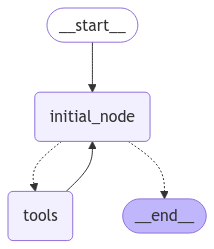

In [44]:
builder = StateGraph(MessagesState)

### Nodes
builder.add_node("initial_node", initial_node)
builder.add_node("tools", ToolNode(tools))

### Edges
builder.add_edge(START, "initial_node")
builder.add_conditional_edges("initial_node", tools_condition) ### TODO: Understand properly
builder.add_edge("tools", "initial_node")

### Compile and display
react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### 6.- Give the graph a try!

In [45]:
messages = [HumanMessage(content="Tell me about the weather and latest news in Madrid")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me about the weather and latest news in Madrid
================================== Ai Message ==================================
Tool Calls:
  get_weather (31aa5ac8-6546-4b07-89f9-a32a1bab5a1a)
 Call ID: 31aa5ac8-6546-4b07-89f9-a32a1bab5a1a
  Args:
    city: Madrid
  get_news (792749df-11b8-4222-899b-e9ccc11bfa93)
 Call ID: 792749df-11b8-4222-899b-e9ccc11bfa93
  Args:
    city: Madrid
================================= Tool Message =================================
Name: get_weather

{"temperature": 9.8, "description": "clear sky", "humidity": 51, "wind_speed": 2.57, "last_updated": "2025-02-03 13:55:41"}
================================= Tool Message =================================
Name: get_news

[{"url": "https://apnews.com/hub/madrid", "content": "(Chema Moya, Pool photo via AP)](https://dims.apnews.com/dims4/default/eb1b474/2147483647/strip/true/crop/2342x1561+0+0/resize/567x378!/quality/90/?url

In [52]:
messages["messages"][-1].content

"The weather in Madrid is clear with a temperature of 9.8 degrees Celsius, 51% humidity, and a wind speed of 2.57 m/s. The latest news about Madrid include articles about Real Madrid's performance in La Liga and Champions League, Kylian Mbappe's potential move to Real Madrid, and other news related to sports, politics, and culture in Madrid.  There are also articles about Spain in general, such as migrant arrivals in the Canary Islands and the country's tourism records."